In [84]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [85]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Data Dictionary
Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [86]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [87]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [88]:
train.shape

(891, 12)

In [89]:
test.shape

(418, 11)

In [90]:
train_id = train['PassengerId']

In [91]:
test_id = test['PassengerId']

In [92]:
ntrain = train.shape[0]
ntest = test.shape[0]

In [93]:
train.drop("PassengerId", axis = 1, inplace = True)
test.drop("PassengerId", axis = 1, inplace = True)

In [94]:
test_id.to_csv('test_id.csv')

In [147]:
ntrain = train.shape[0]
ntest = test.shape[0]
y = train.Survived.values
data = pd.concat((train, test)).reset_index(drop=True)
data.drop(['Survived'], axis=1, inplace=True)
print("data size is : {}".format(data.shape))

data size is : (1309, 12)


In [96]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,373450


In [97]:
data['Title'] = data['Name'].replace(to_replace='(.*, )|(\\..*)', value='', regex=True)

sooooo Jonhkeer is actually a title of nobility apparently https://en.wikipedia.org/wiki/Jonkheer

mlle is french for miss,
Mme is french (madame) so mrs, ms is another abreviation for miss,  replacing these titles with their more common counterparts

In [98]:
data['Title'] = data['Title'].replace(['Mlle', 'Ms', 'Mme'], ['Miss', 'Miss', 'Mrs'])

recreating the change on just the train set to visualize against the ouput variable (suvived)

In [99]:
train['Title'] = train['Name'].replace(to_replace='(.*, )|(\\..*)', value='', regex=True)

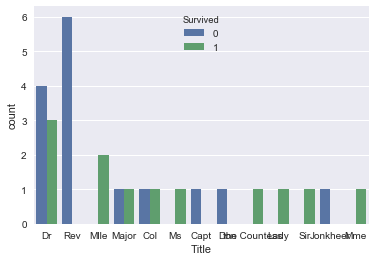

In [100]:
sns.countplot(x="Title", hue="Survived", data=train,  order=train.Title.value_counts().iloc[4:].index)

ok, so here we're looking at all of our rarer occurances. it's interesting to note that most of these have sample size of 1 so they're likely irrelevant- it is interesting to note that all the Rev's died though- but since this is only about 30 total passengers (about 2% of the data) it's probably not worth the time to separate them out.

In [101]:
data['Title'] = data['Title'].replace(['Dr', 'Rev', 'Major',
                                       'Col', 'Jonkheer', 'Major',
                                       'the Countess', 'Sir', 'Lady',
                                       'Don', 'Capt', 'Dona'], "Unusual Titles")

In [102]:
data.groupby('Title').count()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Ticket
Title,,,,,,,,,,
Master,53,9,61,61,61,61,61,61,61,61
Miss,213,60,263,264,264,264,264,264,264,264
Mr,581,135,757,756,757,757,757,757,757,757
Mrs,171,77,197,198,198,198,198,198,198,198
Unusual Titles,28,14,29,29,29,29,29,29,29,29


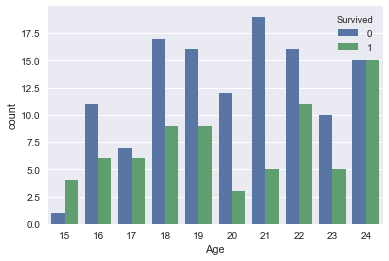

In [103]:
sns.countplot(x="Age", hue="Survived", data=train,
              order=train.Age.iloc[15:25].index)

ok, so looking through this age isn't quite as clean cut as i'd expect- it does look like the older people (30+) tended to survive a little more than the younger people 17-21 especially)- trying binning ages by 15 years until over 45, which'll include all ages

In [104]:
data['Age bin'] = pd.cut(data['Age'], [1, 15, 30, 45, 67], labels= ['Child', 'Young Adult', 'Adult', 'Old Adult'])

# Missingness

ok, now that I've added a couple columns I want to go back and see what we're dealing with for missingness.  should have probably done this to start with, since i see quite a few missing in age and I created that bin for age already. oh well i'll fix it on the next iteration 

In [105]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(6)

,Total,Percent
Cabin,1014,77.463713
Age bin,293,22.383499
Age,263,20.091673
Embarked,2,0.152788
Fare,1,0.076394
Title,0,0.000000


### Cabin

there's just too much missing here for me to feel comfortable using this variable, just going to drop it

In [106]:
data = data.drop(['Cabin'], axis=1)

### Embarked

In [107]:
data.groupby(['Embarked', 'Pclass']).agg({'Fare':['min', 'max', 'mean', 'median']})

Fare                               
                     min       max        mean   median
Embarked Pclass                                        
C        1       25.7417  512.3292  106.845330  76.7292
         2       12.0000   41.5792   23.300593  15.3146
         3        4.0125   22.3583   11.021624   7.8958
Q        1       90.0000   90.0000   90.000000  90.0000
         2        9.6875   12.3500   11.735114  12.3500
         3        6.7500   29.1250   10.390820   7.7500
S        1        0.0000  263.0000   72.148094  52.0000
         2        0.0000   73.5000   21.206921  15.3750
         3        0.0000   69.5500   14.435422   8.0500

In [108]:
data[data['Embarked'].isnull()]

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Ticket,Title,Age bin
61,38.0,NaN,80.0,"Icard, Miss. Amelie",0,1,female,0,113572,Miss,Adult
829,62.0,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,1,female,0,113572,Mrs,Old Adult


OK, so it looks like median is a better descriptor than mean (due to outliers), looks like the passengers are most likely embarked from from C (median of $76.72)

In [109]:
data['Embarked'] = data['Embarked'].fillna('C')

### Fare

In [110]:
data[data['Fare'].isnull()]

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Ticket,Title,Age bin
1043,60.5,S,NaN,"Storey, Mr. Thomas",0,3,male,0,3701,Mr,Old Adult


we know this one's 3rd class from S, I don't see any problem with just filling the na with the median of that bracket ($8.05)

In [111]:
data['Fare'] = data['Fare'].fillna(8.0500)

### Age

In [112]:
data.groupby('Age').count()

,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Ticket,Title,Age bin
Age,,,,,,,,,,
0.17,1,1,1,1,1,1,1,1,1,0
0.33,1,1,1,1,1,1,1,1,1,0
0.42,1,1,1,1,1,1,1,1,1,0
0.67,1,1,1,1,1,1,1,1,1,0
0.75,3,3,3,3,3,3,3,3,3,0
0.83,3,3,3,3,3,3,3,3,3,0
0.92,2,2,2,2,2,2,2,2,2,0
1.00,10,10,10,10,10,10,10,10,10,0
2.00,12,12,12,12,12,12,12,12,12,12


In [113]:
corrmat = data.corr()

In [114]:
corrmat

,Age,Fare,Parch,Pclass,SibSp
Age,1.000000,0.177286,-0.150917,-0.408106,-0.243699
Fare,0.177286,1.000000,0.221668,-0.558740,0.160388
Parch,-0.150917,0.221668,1.000000,0.018322,0.373587
Pclass,-0.408106,-0.558740,0.018322,1.000000,0.060832
SibSp,-0.243699,0.160388,0.373587,0.060832,1.000000


ok, so PClass is the only thing that seems to possibly have a correlation with age- but it's still below .5 it *might* be safe to ignore and randomly impute values for age... might come back to it later

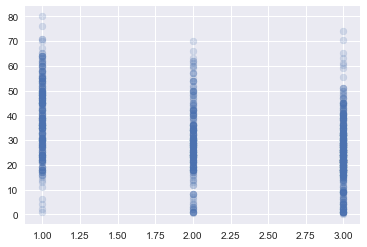

In [115]:
plt.scatter('Pclass', 'Age', data= data, alpha = .2)

ok, this looks wide enough that I'm not particularly worried about it- we're seeing everything across the spectrum in all 3 classes (albeit fewer under 10 in 1st class). i'm going to try and randomly assign an age for these people, but i'm going to try and keep the distribution the same as it currently is.  I remember this was easy in r- just ran the mice package

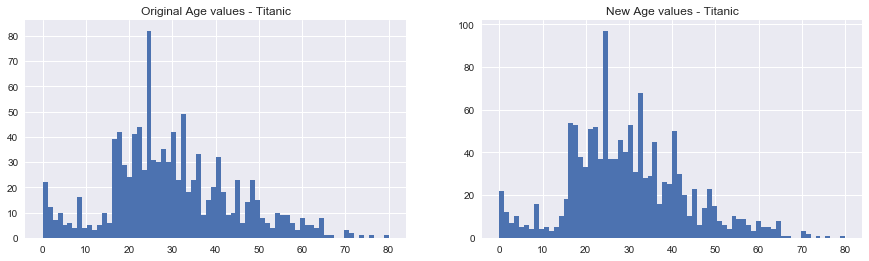

In [116]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age values - Titanic')
axis2.set_title('New Age values - Titanic')

# plot original Age values
# NOTE: drop all null values, and convert to int
data['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# get average, std, and number of NaN values
average_age = data["Age"].mean()
std_age = data["Age"].std()
count_nan_age = data["Age"].isnull().sum()

# generate random numbers between (mean - std) & (mean + std)
rand_age = np.random.randint(average_age - std_age, average_age + std_age, size = count_nan_age)

# fill NaN values in Age column with random values generated
age_slice = data["Age"].copy()
age_slice[np.isnan(age_slice)] = rand_age

# plot imputed Age values
age_slice.astype(int).hist(bins=70, ax=axis2)

In [117]:
data['Age'] = age_slice

ok, so that should keep our variance up more than just imputing the mean age for everything without screwing everything up too much hopefully.

# more feature engineering

In [118]:
data['Age bin'] = pd.cut(data['Age'], [0, 15, 30, 45, 80], 
                         labels= ['Child', 'Young Adult', 'Adult', 'Old Adult'])

i'm not sure how well my blocking off of age will work here, but going to give it a shot

In [119]:
data['Fam Size'] = data['SibSp'] + data['Parch'] + 1

In [120]:
train['Fam Size'] = train['SibSp'] + train['Parch'] + 1

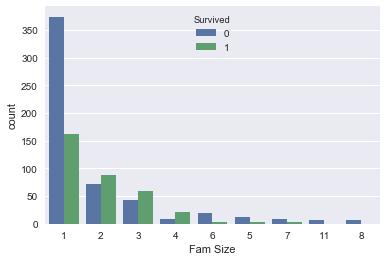

In [121]:
sns.countplot(x="Fam Size", hue="Survived", data=train,  order=train['Fam Size'].value_counts().iloc[:].index)

ok, so this looks like people who were alone had low survival rates, along with families that were larger than 5 people. people in families of size 2-4 ("Small" families) were more likely to live.  i'm going to do some more binning to reduce these to single, small, and large families.

In [122]:
data['Family Size'] = pd.cut(data['Fam Size'], [0, 1, 4, 25], labels= ['Single', 'Small', 'Large'])

In [123]:
data.dtypes

Age             float64
Embarked         object
Fare            float64
Name             object
Parch             int64
Pclass            int64
Sex              object
SibSp             int64
Ticket           object
Title            object
Age bin        category
Fam Size          int64
Family Size    category
dtype: object

to drop: ticket, sibsp, Fam Size

In [125]:
data = data.drop(['Ticket', 'SibSp', 'Fam Size', 'Name'], axis=1)

In [126]:
data.columns

Index(['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'Title', 'Age bin',
       'Family Size'],
      dtype='object')

In [127]:
# Create a list of features to dummy# Create 
todummy_list = ['Embarked', 'Sex', 'Title', 'Age bin', 'Family Size']

In [128]:
def dummy_df(df, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False, drop_first=True)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

In [129]:
X = dummy_df(data, todummy_list)
print(X.head(5))

    Age     Fare  Parch  Pclass  Embarked_Q  Embarked_S  Sex_male  Title_Miss  \
0  22.0   7.2500      0       3           0           1         1           0   
1  38.0  71.2833      0       1           0           0         0           0   
2  26.0   7.9250      0       3           0           1         0           1   
3  35.0  53.1000      0       1           0           1         0           0   
4  35.0   8.0500      0       3           0           1         1           0   

   Title_Mr  Title_Mrs  Title_Unusual Titles  Age bin_Young Adult  \
0         1          0                     0                    1   
1         0          1                     0                    0   
2         0          0                     0                    1   
3         0          1                     0                    0   
4         1          0                     0                    0   

   Age bin_Adult  Age bin_Old Adult  Family Size_Small  Family Size_Large  
0              0      

In [164]:
X = X[:ntrain]
test = X[ntrain:]

In [157]:
X.shape

(891, 16)

In [158]:
y.shape

(891,)

In [159]:
# Use train_test_split in sklearn.cross_validation to split data into train and test sets
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=1)

In [160]:
# Use feature selection to select the most important features
import sklearn.feature_selection

select = sklearn.feature_selection.SelectKBest(k=16)
selected_features = select.fit(X_train, y_train)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [X.columns[i] for i in indices_selected]

X_train_selected = X_train[colnames_selected]
X_test_selected = X_test[colnames_selected]


In [161]:
print(colnames_selected)

['Age', 'Fare', 'Parch', 'Pclass', 'Embarked_Q', 'Embarked_S', 'Sex_male', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Unusual Titles', 'Age bin_Young Adult', 'Age bin_Adult', 'Age bin_Old Adult', 'Family Size_Small', 'Family Size_Large']


In [162]:
# Function to build model and find model performance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def find_model_perf(X_train, y_train, X_test, y_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_hat = [x[1] for x in model.predict_proba(X_test)]
    auc = roc_auc_score(y_test, y_hat)
    
    return auc

In [163]:
auc_processed = find_model_perf(X_train_selected, y_train, X_test_selected, y_test)
print(auc_processed)

0.8421426541631145


In [167]:
from sklearn.ensemble import RandomForestClassifier as rfc

def rf_model_perf(X_train, y_train, X_test, y_test):
    model = rfc()
    model.fit(X_train, y_train)
    y_hat = [x[1] for x in model.predict_proba(X_test)]
    auc = roc_auc_score(y_test, y_hat)
    
    return auc

In [168]:
auc_rfc = rf_model_perf(X_train_selected, y_train, X_test_selected, y_test)
print(auc_rfc)

0.8216822961068486


In [ ]:
attempt = pd.DataFrame()
attempt['Id'] = test_ID
attempt['SalePrice'] = resultstack
attempt.to_csv('stacksubmit1.csv', index=False)